# Derivatives Hedging

In this notebook we are building an optimal hedging strategy for a Call Options from the market prices of the underlying asset based on Policy based reinforcement learning. This approach is data-driven and 'model free' as it doesnt make any assumptions of the underlying stochastic process. The model can easily extended to incoperate transaction costs and trading limits.


The focus of this notebook are as follows:
* Use Policy based Reinforcement Learning and implementing the Policy Based Learning using LSTM based network.
* Compare the effectivness of the hedging strategy and compare it to the delta hedging strategy using the Black Scholes Delta.
* Evaluate Policy Gradient based Method of reinforcement learning which is a combination of policy and value based reinforcement learning. 
* Understand approaches to understand the reinfrocement learning algorithms and fine tune them.
* Class Structure of python programming. Mentioned step by step in the jupyter notebook.
* Teaching a machine to think like a trader and overall increase automation.


## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Generating the Data](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Plot Paths](#2.1)    
* [4.Evaluate Algorithms and Models](#5)        
    * [4.1. Agent Script](#5.3)
    * [4.3. Training Data](#5.5)       
* [5.Testing Data](#6)   
    * [5.1. Helper Functions For comparison against Black Scholes](#5.1) 

<a id='0'></a>
# 1. Introduction

In this jupyter notebook, we will look at the Policy based Reinforcement Learning Techniques, along with an infused time series, to help us predict the best action, based on the stock prices. 

We follow the idea presented in the paper 'Deep Hedging' (https://arxiv.org/abs/1802.03042) by Hans Bühler, Lukas Gonon, Josef Teichmann, Ben Wood and the work of Hutchinson et. al. 'A Nonparametric approach to pricing and hedging derivative securities via learning network' (http://alo.mit.edu/wp-content/uploads/2015/06/A-Nonparametric-Approach-to-Pricing-and-Hedging-Derivative-Securities-via-Learning-Networks.pdf).

We will train a RNN network to learn a optimal hedging strategy given the individual risk aversion of the trader (we will minimize the conditional Value at Risk or Expected Shortfall of the hedging strategy) and derive the option price from this hedging strategy.

In this part we implement a basic 3 layer LSTM network in TensorFlow and we train the model on a Black Scholes process with a drift of zero (risk free interest is zero) and a volatility of 20%. The training option matures in one month and has a moneyness of one ( 𝑆/𝐾=1) .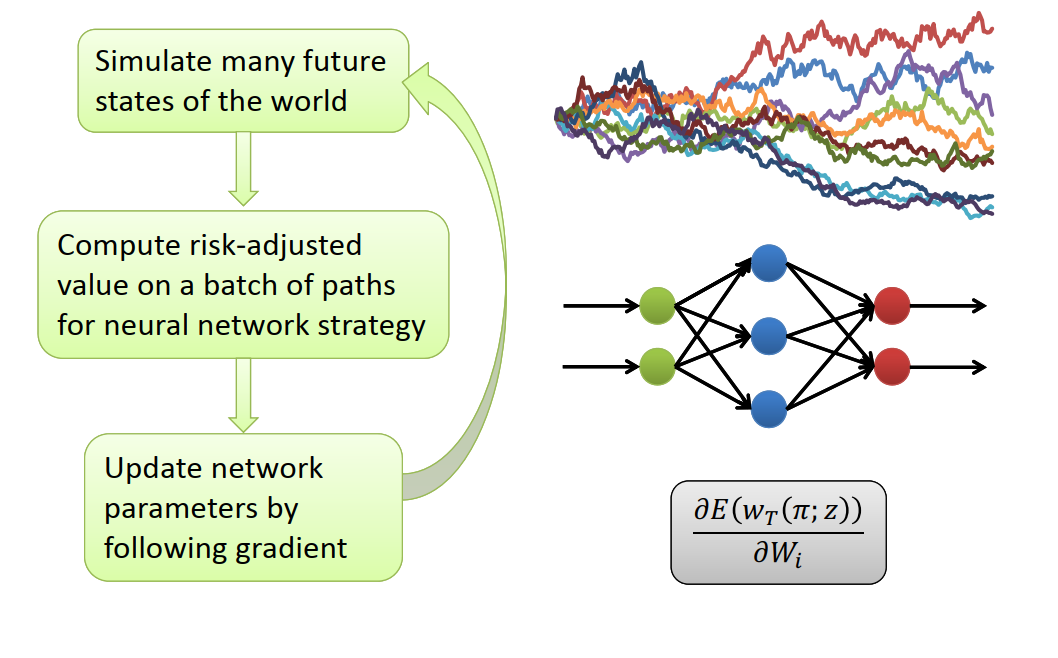


**Terminology**

* Agent: Reinforcement Learning object acting as a "bike re-balancing operator"
* Policy: agent's behaviour function, which is a map from state to action
* Value Function: a prediction of future rewards
* Model: agent's representation of the environment
* Environment: Simulation Stock price 
* State: Instrument's Price in the market
* Training: interactions between the agent and environment for the agent to learn what the goal is and how to achieve it the best
* Episode: number of independent training session (the environment is reset, but agent keeps the learning from one episode to another).
* Session: each session has multiple episodes with both environment and agent reset; the goal is to benchmark agent performances based on the number of episodes (e.g. will more training episode leads to high success ratio? When should we stop the training?)
* Action : Best Replication Straategy

**POLICY**

Policy learning is a more straightforward alternative in which we learn a policy function, π, which is a direct map from each state to the best corresponding action at that state. 


**DATA**

For simplicty we use synthetic market prices of the underlying gernerated by a Black Scholes Process. This can easily adopted to more spohisticated models (see the reference paper for a Heston Model example) or even use real market data.



Additional:
* Understand the test output
* More Epoches


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [71]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats
import seaborn as sns
from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
import tensorflow as tf
from collections import namedtuple, deque

In [10]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Generating the Data 

The function below generates the Monte carlo paths for the stock price and get the Option price on each of the Monte Carlo Path

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$


In [2]:
def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
    """
    Create random paths of a underlying following a browian geometric motion
    
    input:
    
    S_0 = Spot at t_0
    time_to_experiy = end of the timeseries (last observed time)
    sigma = the volatiltiy (sigma in the geometric brownian motion)
    drift = drift of the process
    n_sims = number of paths to generate
    n_timesteps = numbers of aquidistant time steps 
    
    return:
    
    a (n_timesteps x n_sims x 1) matrix
    """
    if seed > 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, n_timesteps)
    S = S_0
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    r = drift
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

In [112]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed = 42
n_sims = 5000

In [113]:
# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, seed, n_sims, timesteps)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Plot Paths

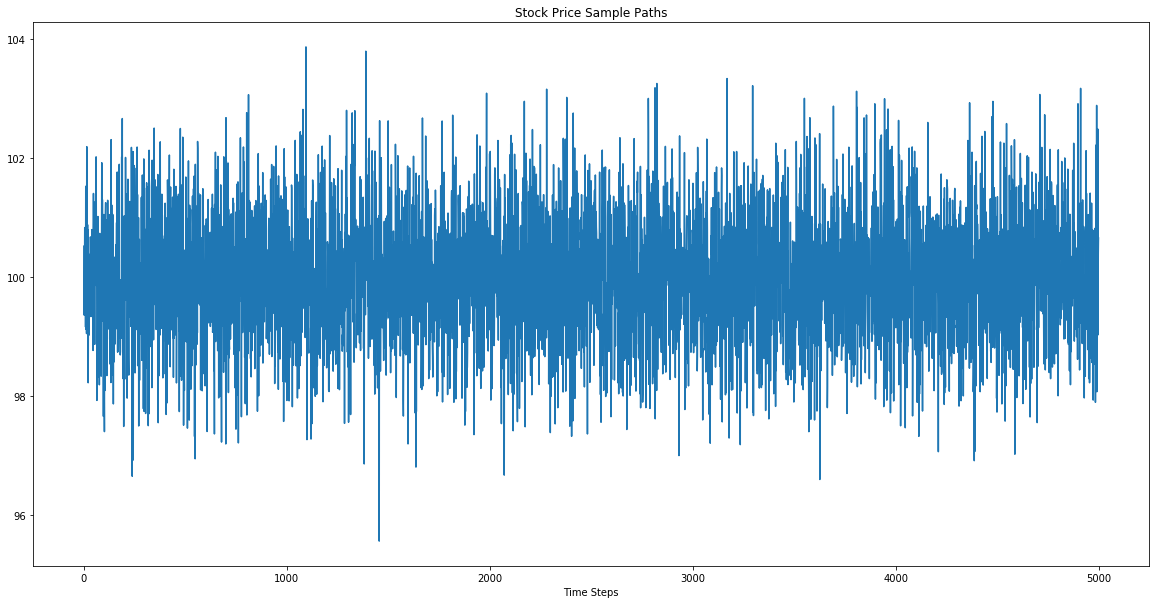

In [5]:
#Plot Paths for one simulation
plt.figure(figsize=(20,10))
plt.plot(paths_train[1])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


<a id='4'></a>
# 4. Evaluate Algorithms and Models

<a id='5.1'></a>
## 4.1. Policy Gradient- RNN-LSTM Network


We wrap out network in the class RnnModel in the following steps:

* In the constructor we build the computational graph in TensorFlow using the `LSTMCell` and stack them with the `tf.MultiRNNCell`. 
* Our loss is the $\alpha$-CVaR. We sort the negative realized PnLs of the trading strategy and calculate the mean of the $1-\alpha$ top losses.

* The class provide a function to train the model in batches (applying a stochastic gradient descent optimizer) and a method to make prediction. Trained with the Adam optimizer with a learning rate of 0.01 and a batch size of 1000.

<a id='5.3'></a>
## 4.3. Policy Gradient script

In [52]:
class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):
        tf.reset_default_graph()
        self.batch_size = batch_size #NUmber of options in a batch
        self.S_t_input = tf.placeholder(tf.float32, [time_steps, batch_size, features]) #Spot
        self.K = tf.placeholder(tf.float32, batch_size) #Strike 
        self.alpha = tf.placeholder(tf.float32) #alpha for cVaR

        S_T = self.S_t_input[-1,:,0] #Spot at time T
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0] # Change in the Spot price
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Build the lstm
        lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n) for n in nodes])

        #So the state is a convenient tensor that holds the last actual RNN state, ignoring the zeros. 
        #The strategy tensor holds the outputs of all cells, so it doesn't ignore the zeros. 
        self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=lstm.zero_state(batch_size, tf.float32), dtype=tf.float32)

        self.strategy = tf.reshape(self.strategy, (time_steps-1, batch_size))
        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy
        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)
        self.train = tf.train.AdamOptimizer().minimize(CVaR)
        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch      
            pnls = []
            strategies = []            
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, hedging PnL and strategy using the inputs 
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            #set_trace()
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    #Saving the model
                    self.saver.save(sess, "model.ckpt")
        self.saver.save(sess, "model.ckpt")
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)
    
    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)
        
    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

<a id='5.2'></a>
## 4.2. Training the data

We will proceed to train the data, based on our policy based model. This will provide us with the strategy, based on the simulatd price. of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps: 
* Define the risk aversion parameter for cVaR, number of features, strike and define the batch size with which the neural network will be trained.
* Instantiate the Policy Gradient Agent which has the RNN based policy with the loss function or the reward function based on the cVaR reward
* The Training data is the Monte Carlo Path generated in the previous step. 
* We can start to iterate through the batches and the strategy is based on the policy that is the output of the LSTM based network. 
* The trained model is saved


In [114]:
batch_size = 1000 
features = 1 
K = 100
alpha = 0.50 #risk aversion parameter for cVaR
epoch = 101 #It is set to 11, but should ideally be a high number 
model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')


In [115]:
# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1])*K, alpha, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:00:03.326560
Epoch 0 CVaR 4.0718956
Time elapsed: 0:00:15.778372
Epoch 10 CVaR 3.741961
Time elapsed: 0:00:26.244520
Epoch 20 CVaR 3.5656495
Time elapsed: 0:00:38.151724
Epoch 30 CVaR 3.1512723
Time elapsed: 0:00:49.424314
Epoch 40 CVaR 3.078078
Time elapsed: 0:00:59.613947
Epoch 50 CVaR 2.9099486
Time elapsed: 0:01:10.961729
Epoch 60 CVaR 2.8450668
Time elapsed: 0:01:21.509489
Epoch 70 CVaR 2.8075178
Time elapsed: 0:01:31.708756
Epoch 80 CVaR 2.7609556
Time elapsed: 0:01:42.488438
Epoch 90 CVaR 2.7813902
Time elapsed: 0:01:53.873620
Epoch 100 CVaR 2.853285
Training finished, Time elapsed: 0:01:56.299444


<a id='6'></a>
# 5. Testing the Data 

<a id='5.1'></a>
# 5.1. Helper Functions for Comparison against Black Scholes

<a id='5.1.1'></a>
## 5.1.1 Black Scholes Price and Delta

In [116]:
def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)

<a id='5.1.2'></a>
## 5.1.2 Test Results and Plotting

In [117]:
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=[0, 1, 5, 10, 15, 29]):
    fig = plt.figure(figsize=(10,6))
    for i, t in enumerate(times):
        plt.subplot(2,3,i+1)
        xs =  paths[t,:,0]
        ys_bs = deltas_bs[t,:]
        ys_rnn = deltas_rnn[t,:]
        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        #df = df.groupby(0, as_index=False).agg({1:np.mean,
        #                                          2: np.mean})
        plt.plot(df[0], df[1], df[0], df[2], linestyle='', marker='x' )
        plt.legend(['BS delta', 'RNN Delta'])
        plt.title('Delta at Time %i' % t)
        plt.xlabel('Spot')
        plt.ylabel('$\Delta$')
    plt.tight_layout()
    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    fig = plt.figure(figsize=(10,6))
    sns.boxplot(x=['Black-Scholes', 'RNN-LSTM-v1 '], y=[portfolio_pnl_bs, portfolio_pnl_rnn])
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')

<a id='5.1.3'></a>
# 5.1.3 Hedging Error for Black Scholes Replication
Function for Black Scholes Hedge Replication

In [158]:
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

<a id='5.2'></a>
# 5.2. Comparison between Black Scholes vs Reinforcement Learning

<a id='5.3.1'></a>
## 5.3.1. Test at 99% Risk Aversion

First, we compare the average PnL and the CVaR of the trading strategies assuming we can charge the Black Scholes price for the option.

For the first test set (strike 100, same drift, same vol) the results looks quite good.

In [121]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed_test = 21122017
n_sims_test = 1000

In [136]:
# Monte Carlo Path for the test set
alpha = 0.99
paths_test =  monte_carlo_paths(S_0, T, vol, r, seed_test, n_sims_test, timesteps)

In [123]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test1_results = model_1.predict(paths_test, np.ones(paths_test.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: 0.02057586703979379
CVaR Hedging PnL: 1.1866961524236046
BS price at t0: 2.302974467802428
Mean Hedging PnL: 0.00626050762759795
CVaR Hedging PnL: 1.9249668655929142


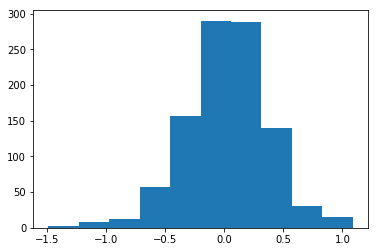

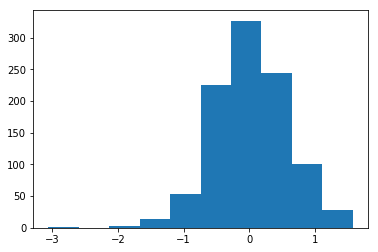

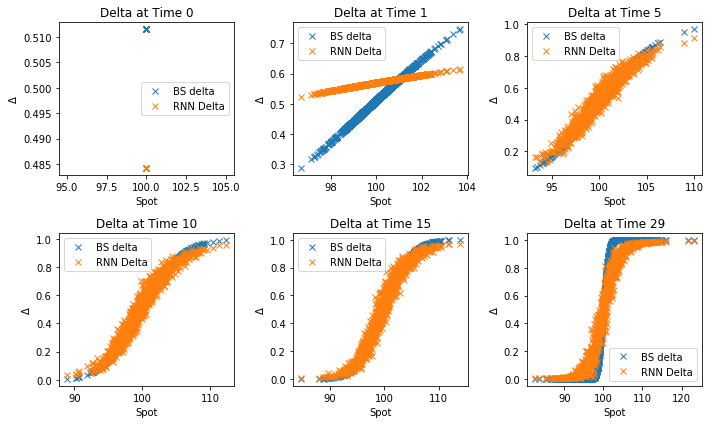

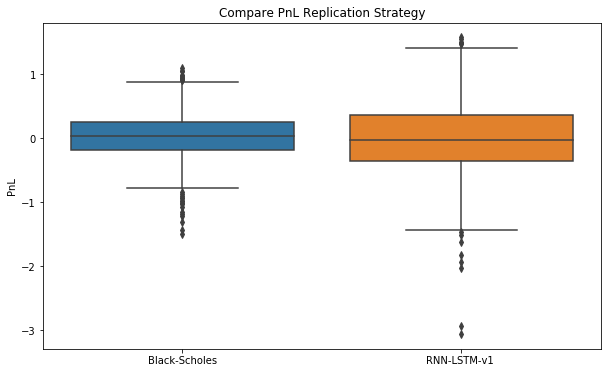

In [124]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.3.2'></a>
## 5.3.2. Changing Moneyness

In [138]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_Moneyness = model_1.predict(paths_test, np.ones(paths_test.shape[1])*(K-10), alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 10.07339936955367
Mean Hedging PnL: 0.0008183521519405606
CVaR Hedging PnL: 0.6765517858337662
BS price at t0: 10.073
Mean Hedging PnL: -0.015881511182771344
CVaR Hedging PnL: 3.848064424319305


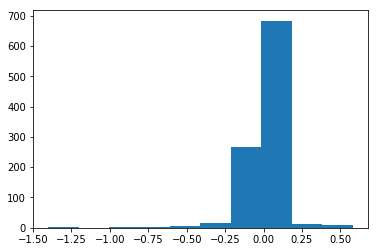

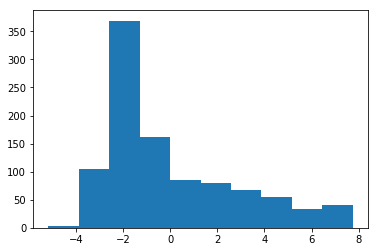

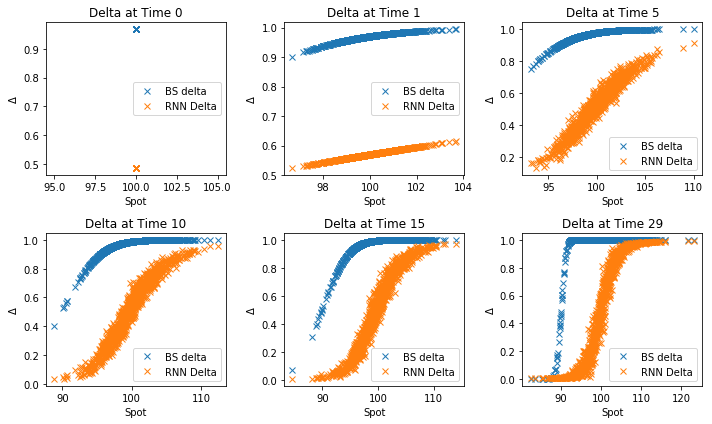

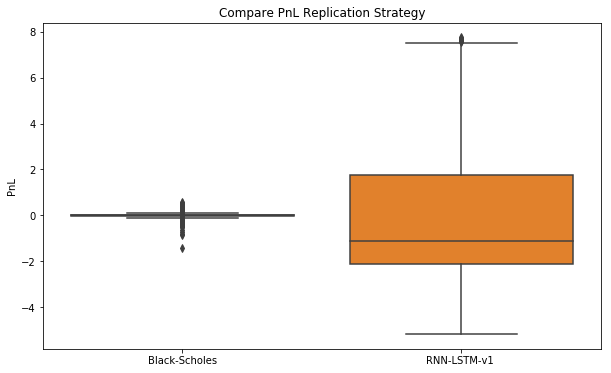

In [139]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-10, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_Moneyness[2], paths_test, K-10, 10.073, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.3.3'></a>
## 5.3.3. Changing Drift

In [147]:
# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_drift = monte_carlo_paths(S_0, T, vol, 0.48+r, seed_test, n_sims_test, timesteps)

In [150]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_drift = model_1.predict(paths_test_drift, np.ones(paths_test_drift.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: 0.0014657907688101427
CVaR Hedging PnL: 1.0551077873760273
BS price at t0: 2.3029
Mean Hedging PnL: -0.020109834117349325
CVaR Hedging PnL: 1.666980487082808


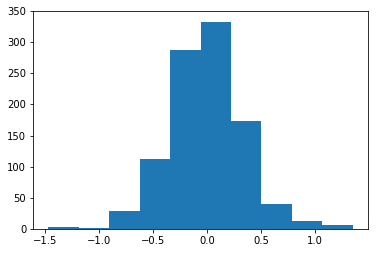

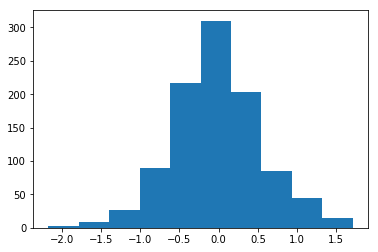

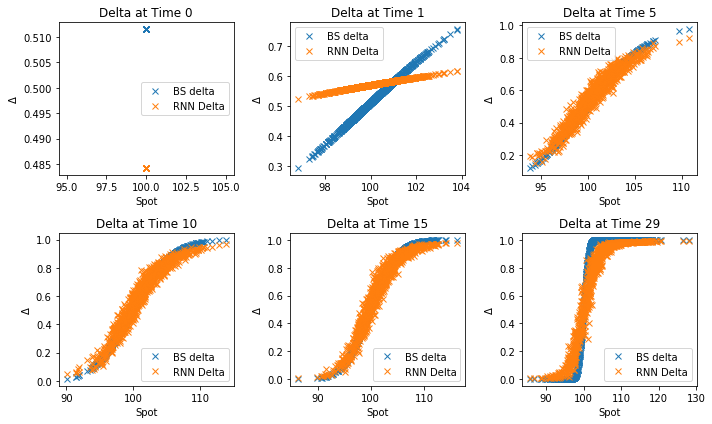

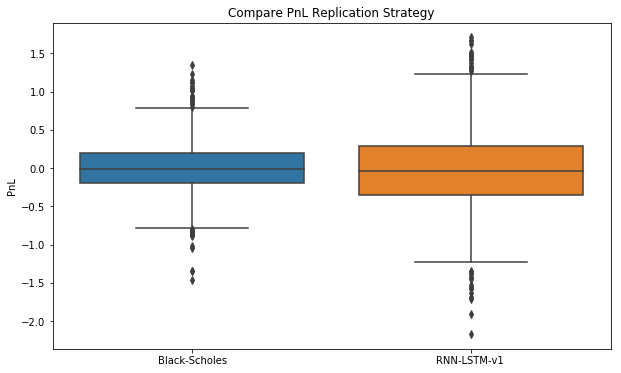

In [151]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K,r, vol, T, paths_test_drift, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_drift[2], paths_test_drift, K, 2.3029, alpha, True)
plot_deltas(paths_test_drift, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.3.4'></a>
## 5.3.4. Shifted Volatility

In [152]:
# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_vol = monte_carlo_paths(S_0, T, vol+0.05, r, seed_test, n_sims_test, timesteps)

In [154]:
with tf.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_vol = model_1.predict(paths_test_vol, np.ones(paths_test_vol.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5502900864538581
CVaR Hedging PnL: 2.439181137626547
BS price at t0: 2.309
Mean Hedging PnL: -0.5659225242905136
CVaR Hedging PnL: 3.4826718559783436


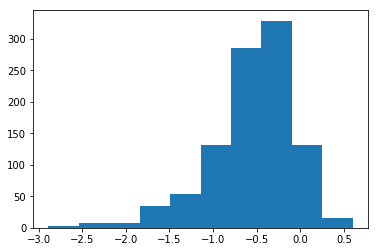

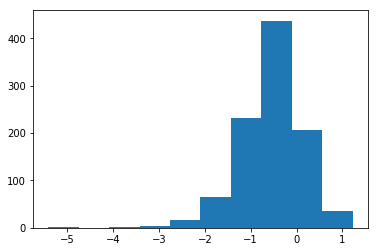

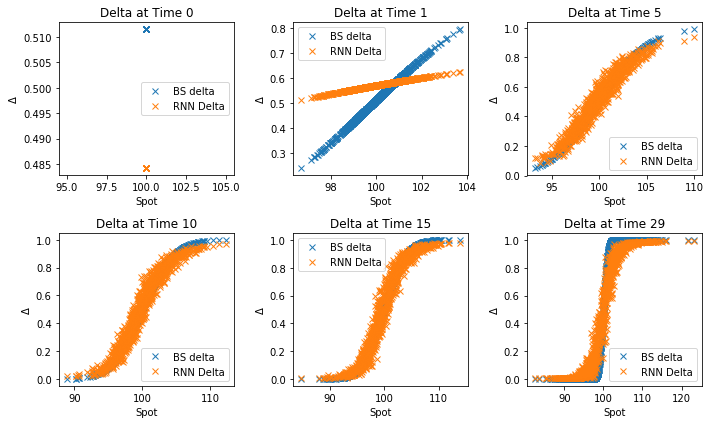

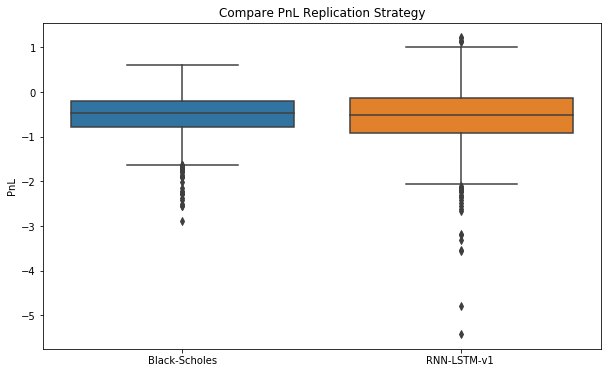

In [157]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_vol, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_vol[2], paths_test_vol, K, 2.309, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

**Conclusion**

* Overall it is a very interesting application of deep learning to option pricing and hedging.

* The Policy Gradient based model is able to learn a hedging strategy for a particular option without any assumption of the underlying stochastic process. The hedging strategy outperforms the Black Scholes delta hedge strategy but the neural network fails at generalising the strategy for options at different strike levels. To be fair we have to admit that our training set consisted only of one option at one strike level.
